In [1]:
# libraries
import torch
from transformers import XLNetConfig, XLNetForTokenClassification
from xlnet_plabel_utils import GWSDatasetFromPandas 
import itertools
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
# suppress warnings
import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/nfs_home/nallapar/miniconda3/envs/dlbind/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# global variables
id_to_codon = {idx:''.join(el) for idx, el in enumerate(itertools.product(['A', 'T', 'C', 'G'], repeat=3))}
codon_to_id = {v:k for k,v in id_to_codon.items()}

In [4]:
# model parameters
annot_thresh = 0.3
longZerosThresh_val = 20
percNansThresh_val = 0.05
d_model_val = 512
n_layers_val = 6
n_heads_val = 4
dropout_val = 0.1
lr_val = 1e-4
batch_size_val = 2
loss_fun_name = '4L' # 5L

# model name and output folder path
# output_loc = '/nfs_home/nallapar/final/riboclette/riboclette/models/xlnet/pseudolabeling/saved_models/XLNet-PLabelDH  Exp: exp1 [NL: 6, NH: 4, D: 512, LR: 0.0001, BS: 2, LF: 4L, Dr: 0.1, S: 2]' 
output_loc = '../saved_models/XLNet-PLabelDH  Exp: exp1 [NL: 6, NH: 4, D: 512, LR: 0.0001, BS: 2, LF: 4L, Dr: 0.1, S: 2]' 

condition_dict_values = {64: 'CTRL', 65: 'ILE', 66: 'LEU', 67: 'LEU_ILE', 68: 'LEU_ILE_VAL', 69: 'VAL'}
condition_dict = {v: k for k, v in condition_dict_values.items()}

class XLNetDH(XLNetForTokenClassification):
    def __init__(self, config):
        super().__init__(config)
        self.classifier = torch.nn.Linear(d_model_val, 2, bias=True)

config = XLNetConfig(vocab_size=71, pad_token_id=70, d_model = d_model_val, n_layer = n_layers_val, n_head = n_heads_val, d_inner = d_model_val, num_labels = 1, dropout=dropout_val) # 64*6 tokens + 1 for padding
model = XLNetDH(config)

# load model from the saved model
model = model.from_pretrained(output_loc + "/best_model")
model.to(device)
# set model to evaluation mode
model.eval()

XLNetDH(
  (transformer): XLNetModel(
    (word_embedding): Embedding(71, 512)
    (layer): ModuleList(
      (0-5): 6 x XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=512, out_features=512, bias=True)
          (layer_2): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (classifier): Linear(in_features=512, out_features=2, bias=True)
)

In [58]:
condition = 'VAL'
col1a1_codon_seq = [condition_dict[condition]] + [7, 38, 14, 21, 55, 49, 11, 47, 9, 39, 23, 39, 37, 56, 52, 9, 27, 30, 36, 56, 8, 30, 32, 17, 23, 32, 27, 60, 24, 52, 44, 3, 62, 42, 9, 60, 50, 12, 60, 40, 45, 60, 32, 15, 61, 42, 56, 61, 42, 44, 62, 12, 49, 61, 53, 49, 61, 42, 7, 62, 41, 41, 61, 42, 41, 62, 26, 41, 61, 41, 42, 62, 26, 41, 58, 42, 41, 61, 37, 9, 63, 2, 21, 57, 57, 35, 17, 25, 50, 0, 60, 53, 24, 25, 62, 41, 60, 40, 7, 61, 20, 7, 60, 42, 12, 62, 41, 41, 61, 57, 53, 60, 58, 41, 62, 41, 32, 61, 22, 32, 60, 41, 57, 61, 48, 41, 61, 51, 41, 61, 32, 11, 61, 41, 56, 61, 42, 45, 61, 40, 57, 62, 25, 41, 62, 3, 57, 61, 51, 49, 61, 34, 41, 60, 0, 42, 60, 12, 41, 63, 51, 12, 60, 54, 53, 60, 40, 35, 61, 57, 45, 61, 22, 42, 63, 9, 41, 60, 37, 41, 62, 22, 0, 62, 55, 0, 60, 34, 13, 61, 7, 49, 60, 20, 3, 60, 35, 41, 61, 56, 35, 61, 55, 3, 61, 48, 42, 61, 58, 41, 60, 51, 1, 60, 9, 40, 61, 32, 56, 60, 58, 44, 63, 37, 41, 61, 51, 12, 63, 45, 54, 60, 57, 41, 61, 40, 57, 61, 58, 44, 62, 13, 49, 60, 14, 53, 62, 42, 54, 62, 41, 57, 61, 42, 5, 63, 25, 57, 60, 42, 41, 61, 22, 40, 61, 57, 41, 61, 42, 3, 61, 48, 37, 63, 42, 53, 61, 2, 41, 62, 41, 57, 61, 41, 57, 61, 42, 45, 61, 48, 55, 61, 37, 40, 61, 37, 25, 62, 41, 53, 60, 41, 41, 62, 2, 41, 60, 8, 1, 63, 38, 9, 62, 58, 3, 61, 57, 9, 60, 38, 41, 61, 54, 57, 63, 57, 42, 61, 38, 41, 62, 42, 45, 61, 5, 41, 62, 42, 57, 61, 57, 57, 61, 57, 8, 61, 58, 12, 60, 37, 53, 61, 51, 41, 61, 41, 57, 62, 26, 0, 60, 48, 26, 61, 2, 3, 61, 51, 41, 62, 25, 53, 60, 58, 32, 61, 41, 41, 61, 42, 14, 61, 48, 48, 60, 3, 12, 63, 25, 42, 60, 48, 57, 60, 25, 57, 62, 41, 56, 63, 41, 40, 63, 37, 12, 62, 14, 41, 61, 25, 44, 61, 37, 41, 60, 57, 49, 62, 12, 57, 61, 52, 7, 61, 41, 41, 62, 1, 45, 61, 24, 10, 62, 41, 57, 60, 6, 44, 61, 41, 1, 60, 49, 58, 61, 44, 41, 63, 48, 41, 61, 38, 7, 60, 42, 12, 61, 37, 41, 63, 25, 41, 60, 1, 53, 62, 40, 25, 61, 0, 48, 62, 41, 55, 61, 38, 41, 62, 5, 49, 62, 12, 41, 62, 40, 6, 62, 40, 57, 60, 40, 12, 61, 48, 57, 62, 2, 6, 60, 22, 41, 60, 42, 0, 62, 42, 25, 61, 49, 41, 62, 0, 41, 61, 51, 12, 60, 34, 42, 61, 37, 57, 61, 57, 47, 60, 57, 40, 60, 42, 49, 62, 2, 1, 60, 57, 35, 62, 42, 41, 60, 42, 35, 61, 53, 32, 61, 62, 0, 61, 48, 32, 62, 41, 57, 61, 41, 41, 62, 22, 35, 61, 38, 41, 61, 42, 24, 61, 9, 9, 60, 48, 53, 62, 3, 42, 60, 48, 15, 61, 37, 41, 61, 48, 22, 61, 38, 41, 61, 41, 57, 61, 40, 12, 60, 48, 45, 61, 10, 43, 61, 51, 13, 60, 57, 57, 62, 41, 25, 61, 41, 5, 60, 14, 44, 61, 42, 13, 60, 58, 40, 63, 41, 49, 60, 2, 3, 61, 48, 57, 61, 56, 54, 61, 57, 40, 62, 13, 57, 61, 58, 25, 63, 41, 61, 63, 37, 40, 60, 51, 15, 61, 57, 57, 62, 4, 41, 63, 62, 0, 60, 48, 3, 61, 48, 9, 61, 38, 44, 61, 50, 9, 62, 2, 9, 61, 12, 49, 61, 57, 45, 62, 5, 41, 61, 57, 52, 61, 58, 41, 61, 41, 57, 63, 58, 24, 61, 50, 47, 61, 48, 57, 61, 57, 58, 61, 41, 25, 62, 40, 57, 61, 41, 47, 61, 14, 41, 61, 48, 45, 61, 48, 53, 62, 41, 57, 62, 42, 1, 60, 21, 57, 61, 41, 57, 61, 57, 57, 62, 32, 42, 61, 57, 0, 60, 51, 3, 60, 10, 0, 63, 41, 3, 61, 48, 1, 62, 5, 53, 61, 40, 10, 63, 25, 53, 60, 57, 57, 62, 40, 25, 61, 41, 1, 62, 40, 41, 61, 41, 53, 60, 13, 45, 61, 49, 60, 63, 42, 41, 61, 7, 9, 62, 22, 41, 61, 57, 57, 60, 47, 9, 61, 42, 42, 60, 42, 13, 61, 5, 57, 62, 42, 41, 62, 42, 41, 61, 57, 57, 60, 3, 48, 63, 5, 45, 61, 42, 45, 62, 50, 32, 61, 40, 53, 62, 44, 9, 60, 48, 8, 61, 56, 25, 60, 42, 41, 60, 21, 53, 61, 48, 3, 61, 42, 25, 60, 48, 41, 61, 10, 56, 60, 58, 41, 61, 10, 56, 61, 41, 35, 61, 37, 37, 61, 57, 42, 61, 5, 39, 61, 38, 41, 62, 25, 12, 61, 48, 45, 61, 39, 40, 61, 5, 57, 61, 57, 39, 61, 48, 41, 61, 41, 39, 62, 6, 24, 62, 41, 41, 61, 58, 45, 61, 42, 41, 61, 57, 55, 62, 14, 41, 60, 53, 1, 61, 58, 41, 61, 48, 57, 61, 45, 49, 61, 2, 41, 62, 14, 49, 61, 42, 40, 61, 45, 49, 61, 35, 41, 60, 34, 3, 60, 51, 45, 61, 18, 41, 62, 14, 5, 61, 43, 9, 61, 57, 56, 61, 58, 41, 61, 41, 34, 61, 25, 55, 61, 41, 57, 63, 0, 33, 60, 2, 44, 61, 48, 41, 61, 41, 58, 61, 25, 53, 61, 41, 53, 61, 57, 53, 61, 40, 12, 61, 41, 13, 61, 41, 32, 62, 6, 44, 61, 50, 0, 60, 48, 41, 61, 49, 0, 63, 34, 15, 61, 37, 41, 62, 20, 0, 60, 18, 13, 60, 23, 35, 61, 37, 41, 61, 37, 57, 62, 36, 33, 61, 50, 32, 60, 57, 41, 61, 41, 55, 61, 41, 57, 61, 42, 15, 61, 41, 57, 63, 41, 25, 60, 42, 53, 62, 0, 49, 61, 12, 25, 63, 32, 41, 62, 40, 54, 63, 41, 57, 61, 53, 45, 61, 25, 35, 61, 14, 32, 61, 42, 57, 61, 42, 41, 61, 42, 41, 60, 41, 41, 61, 41, 41, 61, 54, 14, 60, 61, 62, 17, 50, 21, 61, 21, 48, 60, 50, 22, 18, 15, 57, 50, 35, 41, 46, 26, 35, 41, 24, 38, 12, 42, 3, 50, 17, 48, 53, 49, 56, 9, 39, 0, 25, 38, 1, 2, 35, 5, 51, 10, 37, 38, 9, 41, 48, 62, 25, 12, 3, 2, 41, 57, 46, 11, 30, 47, 50, 20, 12, 38, 14, 34, 40, 51, 31, 2, 14, 49, 18, 18, 31, 5, 50, 41, 2, 32, 60, 29, 9, 7, 49, 58, 6, 0, 55, 18, 29, 49, 22, 25, 9, 61, 48, 10, 30, 6, 35, 58, 32, 41, 52, 2, 10, 40, 59, 3, 2, 24, 18, 14, 46, 58, 35, 58, 2, 3, 33, 54, 31, 20, 60, 51, 9, 6, 1, 61, 62, 14, 35, 21, 48, 18, 2, 52, 48, 63, 55, 26, 26, 3, 48, 7, 56, 9, 35, 38, 58, 22, 7, 46, 39, 36, 58, 2, 45, 57, 25, 35, 2, 6, 10, 18, 34, 30, 3, 2, 14, 5, 59, 18, 39, 49, 51, 51, 11, 62, 14, 23, 2, 3, 57, 55, 37, 39, 35, 61, 26, 2, 49, 53, 48, 37, 53, 57, 51, 62, 2, 14, 15, 22, 10, 18, 25, 54, 36, 54, 49, 62, 30, 26, 0, 3, 8, 1, 48, 31, 62, 3, 8, 6, 5, 48, 18, 0, 8, 1, 3, 40, 25, 46, 39, 43, 22, 37, 50, 5, 56, 41, 39, 50, 5, 61, 61, 57, 50, 32, 48, 22, 45, 55, 51, 53, 62, 42, 54, 29, 22, 0, 16]
col1a1_true_counts = [0.0, 0.0, 0.0, 0.0, 0.0, 4.481064961955769, 4.384392991837415, 1.3197125357282582, 1.2029418483961312, 2.117879294625069, 0.8845601497787398, 1.1805821241212429, 0.03213407349104844, 0.11295570045618537, 0.1955293011596726, 0.0, 0.0, 0.0983886745865515, 0.08132841078432418, 0.09207789597909387, 0.15315252629304174, 0.16662972979546076, 0.12456338573738138, 0.6219564790969029, 2.1632096938916026, 0.6616083937501518, 0.445277542842228, 1.594621920923269, 1.201999427888752, 1.3026443062339184, 0.39736938092680285, 0.8050935958188711, 0.9119726937473099, 1.7679334877746993, 0.9380711501692994, 0.5357152933773097, 0.4194898215241349, 0.4963792214258022, 0.2920487618203459, 1.1667890779170824, 0.700399250222707, 0.4091298799610245, 0.41964774287500556, 0.48531644732821366, 1.1113983441096098, 0.6657338114346449, 0.9993037018341179, 1.0648144849364554, 1.8360169259280825, 0.6706386206778014, 0.08335299226215058, 0.3435374302366568, 1.312383081884581, 0.4471467567681062, 0.7247047474476588, 0.653662577296527, 0.8302598469291715, 0.4200398403055874, 0.8966316882122025, 0.1645260354945266, 0.0706551803183949, 0.06193027660145162, 0.10345140518057876, 0.3996255846854178, 0.06707196787091421, 0.22769894821621872, 0.30887199144859473, 0.1804936188352717, 0.07517299972881472, 0.13126115417757575, 0.7715942341268643, 0.256950087995342, 0.05055676739996675, 0.03692434849327196, 0.13379267162226177, 0.08202868951987978, 0.202227069599867, 0.18127301039393506, 0.7461277674037025, 0.15400817258054547, 0.3508617764824889, 0.7656812691385232, 0.23884369323118237, 0.12253625046063245, 0.08214577755973534, 0.36613193918194575, 0.09640222047314531, 0.12168060417312869, 0.5312028858600798, 0.07011026913478748, 0.27701307949594495, 1.9311460443133346, 0.4296969493342197, 2.5227150117643498, 1.8396130595178484, 0.06746166365024589, 0.8436604914074053, 0.7006334263024181, 0.120590477510569, 0.0661373609079751, 0.06625460109550306, 0.0, 0.03014761937764225, 0.10477570792284953, 0.7631851731116625, 3.2303623535040487, 1.8232473582626418, 0.40063915232379227, 0.0865465089302996, 2.992450865584555, 1.4894435960788026, 1.7943474826030854, 0.8741951006177843, 2.4514329493449725, 0.7359203352982728, 0.23705042973879972, 0.5597103597937099, 0.3598974153033285, 0.0661373609079751, 0.04720788317986956, 0.24600981383079898, 0.2439852323529726, 0.08888437931094484, 0.04919433729327575, 0.9950966175275945, 0.641586235560564, 0.6134657514596706, 2.7062493335147444, 2.373377168051905, 0.36114546331675895, 0.16031895118800313, 5.854507047065418, 4.351738452646532, 0.12257693162397518, 0.03412052760445462, 0.392851561516383, 0.3090299127994654, 0.046038947989546934, 0.19770925018944718, 0.5456116860834981, 2.7495477942020297, 0.21375850015222256, 0.4479261483267696, 0.0706551803183949, 0.708187145325461, 0.7604603128982804, 0.04736325073181772, 0.41318445480986715, 2.190861521537729, 0.7819592832878198, 0.6775759770908968, 0.5331483545147985, 0.2251320093537074, 2.7740217322688867, 0.3574832901938428, 0.9025500650937336, 0.1658503382367974, 0.41598556975208956, 1.6318491909759973, 1.8882897892055572, 2.4950418408408086, 0.39308062999824905, 4.895439151135356, 2.637218671551482, 0.523486137888321, 4.039733876465093, 2.5516199950217513, 1.3870054542412535, 1.1298674353704055, 1.325783117772125, 1.2664149767306847, 0.8995907245052956, 0.055971066408905465, 0.15081465591239648, 0.929967412364804, 2.2357292848333756, 4.76965988444834, 0.8360203024598318, 0.7567981397753644, 1.6102736615622728, 0.7990986599131548, 0.4629618306511705, 0.33761905335512576, 0.22061418994328763, 0.7032057770581193, 2.4694330798556563, 0.24312703226654628, 0.7918559802893531, 0.1526838698382747, 2.726740148159099, 0.5831602107311578, 0.5063521731561759, 1.7522868547335406, 4.233883659135725, 0.7869511710461965, 0.4352283363830139, 0.7151241974432115, 1.6820186642478825, 1.1102319627182096, 1.1689690269468571, 0.38023000430146775, 0.6716576002093658, 1.2645508704026514, 1.08070581354836, 0.03412052760445462, 0.0, 0.535328303544573, 0.6533467345947855, 2.4845293898200174, 0.9433629492451927, 4.25449031716681, 6.007453249264224, 0.2338569130706507, 1.5683445041683388, 0.28207581008997223, 2.2926781931674856, 0.9770253398859152, 0.7377132944953106, 2.622193204422771, 2.962460863262439, 0.17776875862188968, 0.03692434849327196, 0.2889314998810373, 0.38132013096402745, 0.5322110416052643, 0.19319143077902737, 3.3174324303405407, 1.591881129325662, 1.262136440997821, 1.5421851158110442, 1.481034230768256, 1.0440183470813942, 0.4050807170053717, 0.26797744067510537, 1.1557259995241491, 0.16086386237161057, 1.5277760112922811, 0.39292781624522344, 0.994469735426612, 0.05199815818209309, 0.2510725444248262, 0.45828608988988, 7.654058337343141, 1.0297620563156564, 0.5038563814246599, 0.9237383003793767, 2.1857984866483573, 1.4237034401992545, 0.8349355876904619, 0.5259056748909966, 1.3712774588734096, 0.5254370184362296, 0.339488267281004, 0.2879179322426628, 0.120590477510569, 0.2072135454650538, 0.08756007656867405, 0.03412052760445462, 0.13172981063234276, 0.04919433729327575, 0.0, 0.64524840868348, 0.04370107760890168, 0.03014761937764225, 0.0706551803183949, 0.08202868951987978, 0.25111322558816895, 0.17994870765166426, 0.07330378580293649, 0.43834559832232256, 0.07735550255751181, 0.0602952387552845, 0.0, 0.08974002559844861, 0.1043070514680825, 0.410612104054166, 0.23463630462931406, 0.04720788317986956, 0.11801843105021265, 0.9303598140907305, 1.0978499934761954, 0.2495903203316847, 0.18859735663976715, 0.2064722812708107, 0.1439589661213314, 0.522319756496921, 0.3156514265108194, 0.20908275939093204, 0.14847678553175123, 0.46179034166192534, 0.7125521509828552, 0.5434320413490684, 0.5932094171903718, 0.6357441134078734, 0.12900239662003823, 0.17060263802227313, 0.0602952387552845, 0.2365055185551923, 0.06824105520890925, 0.0661373609079751, 0.6545182235840308, 0.618605041077883, 0.2957871896721023, 0.20869576955819533, 1.3022624239990268, 1.0220507202370877, 0.19366008723379438, 0.06878596639251668, 0.5417970035029013, 1.5664146626025002, 0.49451000749992396, 0.9581695630877277, 0.9992982899409281, 1.9440675128457665, 1.808914812768064, 0.2484239389402846, 2.4854826341137763, 0.10025788851242973, 0.7398169887962448, 2.444343083474196, 1.6054444984572669, 0.42930995950148293, 0.09340219872136467, 0.4109228391580623, 0.7148083547414702, 0.377581703112271, 0.9649435862567625, 0.227780614838249, 0.0, 0.08740215521780335, 0.18446652706208408, 0.15034599945762944, 0.6950206769269384, 0.6422839604971972, 0.25597735366798274, 0.14092066485745813, 0.14769739397308784, 0.42860682267165995, 0.5065866535312318, 0.2844136804706175, 0.06625460109550306, 0.2013714233123632, 0.3937072078038868, 0.09106432834071941, 0.08132841078432418, 0.03213407349104844, 0.8318948847753386, 0.3344255366869768, 0.3399569237357711, 0.15790452178317263, 0.4212065259923323, 0.18415579195818774, 0.43857977440203366, 0.10765848948710222, 0.0587748872977228, 0.1293919402516975, 0.16670598452430116, 0.8135128720297632, 1.099403668995677, 0.4891365418020004, 0.08974002559844861, 0.38490604935810313, 0.39441004033836496, 0.8009729814368782, 0.14361010365301485, 1.5063535999269269, 0.85955182001931, 3.1135970780651108, 0.7021922094197448, 0.2537211499093678, 0.4428634177327424, 0.0, 0.534396098232884, 0.046038947989546934, 0.0, 0.3732218050527219, 0.12487412084127769, 0.8924242996103343, 0.17963797254776792, 4.797795691342768, 2.542502385283537, 0.12300490691539949, 2.8267584486986284, 4.7297680775268445, 2.8880570398965966, 2.3179155914087812, 1.353822239546333, 2.6496874150133713, 3.300451583656766, 1.3315387700002852, 3.391923940812292, 5.79232605440934, 3.955442962702719, 3.1885962250588307, 0.6570089077177017, 3.086086936090286, 4.020180679025618, 0.12456338573738138, 0.33582609415808795, 0.2939179757462241, 0.41364769937144424, 0.34634395707206905, 0.16405737903975956, 2.976935703019007, 0.35187534412086335, 0.03014761937764225, 0.13172981063234276, 0.5429633848943014, 0.18766004373023307, 0.03213407349104844, 0.32219638119798816, 0.7151241974432115, 0.07011026913478748, 0.6151007893058378, 0.6630852059501033, 2.8548894522905566, 2.141324037964672, 0.12035630143085789, 0.4662316020481599, 0.32172772474322114, 0.9480437976043282, 1.6317726319518122, 0.8130442155749961, 0.4442639752038535, 0.4378769418675555, 2.299610137687391, 1.1790944881349115, 5.575710614977435, 1.182216857672065, 1.3291348600864896, 0.3447854782500872, 0.2029299021343451, 1.158456271630721, 0.1235498180990069, 0.6655809976816193, 2.7148214234786625, 4.372687404254619, 0.8102376887395838, 0.5902500766019338, 0.31401638866465226, 0.4187920965875018, 0.6813906596714937, 0.4277511763841562, 1.1325106289617572, 1.8668772887405483, 3.4877348527499525, 4.439980322767614, 1.1113220893807692, 0.5835472005638944, 3.5802105623481624, 1.221786801407939, 0.1222255153567361, 0.11350061163979282, 0.0, 0.04919433729327575, 0.18734930862633678, 0.03412052760445462, 0.03412052760445462, 0.06824105520890925, 0.03412052760445462, 1.5614332943351588, 0.2680536954039458, 0.09242931224633294, 0.06824105520890925, 0.11428000319845617, 1.108520974438547, 0.3185342080750721, 0.24639680366353567, 0.2481897628605735, 0.22700122327958563, 0.04919433729327575, 0.29150354634139364, 0.08132841078432418, 0.0661373609079751, 0.7969187108833803, 2.361774590368554, 0.8882172153038107, 0.4293862142303233, 0.0, 0.09207789597909387, 0.6803770920331192, 0.36722176154916064, 0.23463630462931406, 0.41279205308394046, 0.3192370406095502, 0.16507094667813402, 0.2360368621004253, 0.7340511213723947, 2.5958605719210706, 0.38155430704373855, 1.051963859239674, 0.09285728753775722, 0.05055676739996675, 3.935824030025438, 0.03014761937764225, 0.06824105520890925, 0.08740215521780335, 0.0, 2.8119623543471284, 0.0, 0.0, 0.0, 0.0, 4.630452000931105, 0.3887207319387, 0.046038947989546934, 0.21640710563676416, 0.18361088077458032, 1.3475985394540955, 0.5745115617430548, 0.15478756413920883, 0.6777338984417675, 0.7474517658506284, 0.42011639932977257, 3.292679619938237, 3.276706320408957, 0.2601081832456658, 0.3209483331845578, 1.1240961560533653, 1.7514261008481917, 0.4633488204839073, 0.15953955962933977, 0.07330378580293649, 1.4000140012889055, 0.5553501574388159, 0.3539790384217975, 0.55745385173975, 0.560413192328188, 0.09106432834071941, 0.5942992395575867, 0.03598974153033285, 0.36402824488101154, 1.180342231852997, 0.06625460109550306, 0.8685057922181194, 3.905813293016596, 2.4764361715065566, 2.0581889861026625, 0.39004503468097074, 0.308485001615858, 2.2128951879151857, 0.25644601012274976, 0.41333696426754796, 0.0, 0.3814780523148982, 1.0095819767751981, 1.1450502152592972, 0.05741245719103181, 0.19451573352129817, 0.48204667593122424, 0.49279871492491645, 0.31120986182924, 0.530733925109968, 0.3779738005428528, 1.2272371304253926, 0.45828608988988, 0.1394411467109116, 0.09721958724855646, 0.3550688607890124, 0.3154169461357635, 0.15899464844573233, 0.15073809688821124, 0.04736325073181772, 0.04919433729327575, 0.10664492184872776, 0.046038947989546934, 0.06746166365024589, 0.03598974153033285, 0.04919433729327575, 0.0661373609079751, 0.12168060417312869, 0.8965554334833622, 2.4827523620072043, 1.0398112627748706, 2.945316683334603, 0.17730010216712266, 0.5791873025043454, 0.20503359643527927, 0.7257948741102184, 0.38077521978042, 0.5414046017769747, 2.3409018934893076, 0.4103016732456144, 0.24336120834625738, 1.2491281982455138, 0.37415370606906606, 1.0076419200136693, 1.1816665345952677, 2.4102273591722416, 1.183775336494047, 0.09640222047314531, 0.9422019797469825, 0.7701987842535981, 1.8692103558186934, 1.1490285353792995, 2.4163859326173633, 1.430711943743345, 1.7266516428731282, 0.6912056900509967, 0.398769938397914, 1.4324232363183527, 8.638234475035139, 1.011838180533813, 6.006450809707574, 0.7198764972286873, 0.9007571058966958, 5.5023809868899285, 1.0356858450903774, 0.7892836295336517, 0.18361088077458032, 0.3655867237029935, 0.15471100511502361, 1.000704259305229, 0.10080279969603716, 0.4642807215002514, 1.229106040055926, 0.5016001776660449, 0.8797264876665786, 0.6905079651143636, 0.5904028903549595, 0.8116382462106949, 0.08132841078432418, 3.1744158847265886, 1.9599585371623265, 2.359507867118904, 1.1282269856310485, 2.4556346217583056, 0.16771955216267562, 0.1997363854661961, 0.16904385490494642, 0.8238728135928736, 0.9221032625332094, 0.7823516850137464, 0.2610454961551999, 0.18968717900698198, 0.8019814414774075, 0.19950220938648497, 0.07751087010945998, 0.22092492504718395, 0.08888437931094484, 0.3193898543625759, 0.9726600299331762, 0.4979380045431289, 0.34984820884411444, 0.2656395702944601, 0.2450725009212649, 0.22224922778945475, 0.5621244849031956, 0.2318297777939018, 1.339250106078854, 1.440908552062395, 0.6869223510156327, 0.2657158250233005, 0.5326796980600313, 1.6363615984932272, 1.4171479660210506, 0.609411176610828, 1.2153132981471104, 0.993379913059397, 0.3024849581122967, 0.8610235246214165, 1.8825242260770516, 0.6116676846647878, 0.11934273379248343, 0.07649730247108551, 0.10158219125470051, 2.2649443946039844, 0.21640710563676416, 0.20184007976713025, 0.7148900213635004, 2.467411052176752, 0.7736264770014581, 0.227780614838249, 2.1180318040827495, 1.0018760525898192, 0.9830253833894765, 0.03213407349104844, 0.8689798605660762, 0.9774939963406822, 1.0524328199897859, 0.5664129315364045, 0.7597625879616473, 1.0640408095663265, 0.6002230283323076, 0.4153640995442969, 0.873029023521729, 3.7416244435012254, 0.8463039892941019, 1.6034179717712076, 1.5454660152897581, 0.4812672843725609, 0.2132490103864404, 0.05608815444876102, 0.34135748120688225, 0.0997892320576627, 0.25550869721321573, 0.5291754462879861, 0.33582609415808795, 0.6255369855977886, 0.15953955962933977, 0.8559659016252343, 0.28254446654473925, 0.17730010216712266, 0.29430496557896085, 0.3215698033923504, 0.47674946496214105, 0.0, 0.0587748872977228, 0.4407597234318082, 1.005685323277226, 0.7374791184155995, 0.26478392400695633, 0.6929223945191941, 0.5119598149338106, 0.9608181685722691, 0.49926230728539966, 1.4873501169735588, 0.27249526008552516, 3.8821394811951273, 0.535328303544573, 1.8911782869583444, 2.2212484245929276, 1.9108891014533462, 3.9566367078554134, 0.530347239572576, 0.24889259539505168, 0.5735796607267106, 0.722290622338173, 0.6422128133662017, 0.1849351835168511, 0.0, 0.0, 0.09893358577015893, 1.4602383972085395, 0.35873103391192845, 0.09472650146363544, 0.04736325073181772, 0.280206596164094, 0.9312968227049199, 0.046038947989546934, 1.4419326391918041, 0.21188928622634431, 0.2520861120632007, 0.8675738912017752, 1.4800972221540667, 1.2121248890768064, 1.550365412639725, 1.1609415438712019, 0.5465438913951871, 1.2574610045318753, 2.0697207209503627, 0.8747349042035467, 1.0673814237989665, 0.2291049175805198, 4.179103876045009, 1.4966151285716094, 0.6009207532689406, 0.5085321221859503, 0.3606002478378067, 3.667541266139626, 2.453465496514911, 3.9008529637313245, 1.9105075235137996, 0.8227013246036283, 0.6136185652126963, 1.6289712127142446, 0.1764444558796189, 0.21640710563676416, 0.6788240251043272, 0.5807460856216721, 0.4812672843725609, 0.19739851508555084, 0.07883517285173076, 0.06076134141112899, 0.11248704400141836, 0.5720211819047288, 0.12035630143085789, 0.05741245719103181, 2.81461637172486, 0.13172981063234276, 0.03692434849327196, 0.42455765971600723, 0.3432266951327605, 0.6473517986890694, 1.0364544128626612, 0.5083742008350797, 1.8325940364827227, 1.0941013504287487, 0.5456882451076833, 1.6707925569062334, 0.48453736006489506, 0.27467520911529975, 0.41738612722320073, 0.35351038196703044, 0.6656575567058045, 0.491785147286542, 0.5834709458350541, 1.3588087154115198, 2.1018195251712584, 2.814131783885868, 7.327018687427992, 4.871236359514505, 1.8180267063177442, 3.3568606884051135, 1.7539113730886726, 0.42580060013159254, 1.1576714681788678, 1.2073674816934856, 0.0, 0.06878596639251668, 0.08202868951987978, 0.07969081913923452, 0.3644152347137483, 0.3557665857256455, 0.9764699092112729, 0.35241514770662574, 0.11061783007554014, 0.3603660717580956, 1.6139307270873438, 0.8456774114884641, 0.743713337998872, 0.5740483171814778, 1.6207152697474132, 1.0246993257216293, 0.3029536145670637, 1.0411355655171415, 0.40586010856403504, 0.07735550255751181, 0.21640710563676416, 0.8840101309972873, 0.22411844171533293, 0.5002704630305842, 0.16218816511388134, 0.694012216886409, 3.79506429676079, 0.3185342080750721, 0.6884808298376147, 0.04736325073181772, 2.0187058165866643, 0.37727096800837473, 1.408357327066302, 1.7987182044490142, 0.15182822355077094, 0.8691326743191019, 0.6422077057683566, 2.0134848603464213, 1.90380464747576, 1.1213767077331733, 0.22731195838348198, 0.30949856925423247, 1.5345554463545057, 1.8340759562805193, 6.988422428210097, 2.655545468550287, 0.807125838693465, 2.468343257488441, 5.061865046142832, 0.8944463272892381, 0.7323398287973871, 0.32359693866909933, 2.1428719972956185, 0.2924357516530826, 0.1175497745954456, 0.177610837271019, 0.06512379326960065, 0.36955963192980584, 0.15073809688821124, 0.0, 0.10236158281336387, 0.06746166365024589, 0.16405737903975956, 0.44660184558449884, 0.13250920219100612, 0.08756007656867405, 0.25450054146803114, 0.41808926405302366, 0.03598974153033285, 0.03014761937764225, 0.046038947989546934, 0.8868115502348545, 0.23596060737158486, 0.928648521515723, 0.0983886745865515, 0.5290991915591456, 0.1891422678233746, 0.5714759664257766, 1.8839401063416983, 1.3168243422708155, 0.5243471960690147, 0.5074422998187356, 0.6516354420197781, 0.4229991808940253, 0.2907244590780751, 0.22645631209597825, 0.5066629082600722, 0.161877430009985, 1.682411065973809, 1.0844496532933063, 1.4075016807787983, 1.770826788829987, 0.4772946804410933, 0.3843608338791508, 0.7723838408812177, 1.0593647645096913, 0.6027134081706337, 1.3017124052175744, 0.07517299972881472, 0.0, 0.06824105520890925, 0.19630869271833598, 0.5033877249698929, 1.3211737208393297, 0.5086083769147909, 0.11614921712433442, 0.2072898001938942, 0.22131191487992066, 0.9270897383983963, 0.4374082854127885, 0.0, 0.8042376452360225, 6.666826478237831, 0.6809274151099164, 0.1175497745954456, 0.1426346633790606, 0.5606473684078991, 0.4614033518291887, 0.8929695150892866, 0.4531468002716676, 4.3878759003320456, 1.8382830405870427, 3.663175956186887, 0.6740717253188514, 1.95397442504299, 2.788976052266602, 1.0409064970352755, 0.2828552016486356, 0.9615210011067473, 0.2757650314825146, 0.09472650146363544, 0.2857379832128883, 0.2830893777283467, 0.9707908160072979, 1.3059903323597484, 1.041762143322779, 0.9822459918308132, 0.3990806735018104, 0.6437661845903385, 0.5730344452477584, 0.5828494756272614, 1.1829091707155084, 0.8243360581544508, 2.0361454088248605, 3.438971044547023, 0.7479204223053953, 0.6478153475459912, 1.5744316261871203, 0.19233578449152358, 1.285194498800032, 0.9847366759644841, 3.065296514423759, 0.30053918516223327, 0.09340219872136467, 0.06878596639251668, 0.9915161110267087, 4.416159717677, 2.057420418330379, 0.08335299226215058, 0.775882985055418, 1.8270623451385835, 1.4483196725281025, 0.1261984235835485, 0.1804936188352717, 0.03692434849327196, 0.3856851366214216, 0.8913341729477745, 0.6352754569531064, 2.5217014441259753, 0.03014761937764225, 0.03412052760445462, 0.5754488746525889, 0.545143333924076, 2.562295474991258, 3.162828934132117, 0.8519167386695816, 0.648441925351629, 0.7592939315068804, 0.761086890703918, 1.1440417552187678, 0.259252536958162, 0.4733217722142809, 1.3798396379369817, 0.23572612699652895, 1.9462627846690763, 0.33037637373132395, 0.7064755484551086, 0.658725612185899, 1.1352405967729842, 0.6311500392686131, 0.22933909366023095, 0.4013422891536152, 0.6578696616030505, 0.42541361029885577, 1.115845016389034, 0.12456338573738138, 0.1917908733079162, 0.09075359323682308, 1.0747057700447986, 0.3040434369342786, 0.2227941389730622, 0.756956061126235, 0.2010606882084669, 0.691287356673027, 0.45104341026607825, 0.15026974472878904, 0.05055676739996675, 1.831274841338297, 2.2908089792416075, 1.0106772110356028, 4.524902921933471, 0.46436238812228176, 0.17091306883082466, 0.9429813713056459, 0.16171950865911433, 0.15533247532281627, 0.08888437931094484, 0.504090557504371, 0.2350232944620508, 0.46171378263774016, 0.06878596639251668, 0.09527141264724288, 1.318464487714828, 0.5200635527383061, 4.5898084705075854, 2.462582801957781, 0.27413029793169225, 0.3344255366869768, 0.4815017647476168, 0.3838159226955434, 0.238025870012754, 0.28924223498493357, 0.43421476874463943, 0.12257693162397518, 0.0, 0.12253625046063245, 0.12654983985078755, 1.5951617245090315, 0.17589954469601146, 0.14361010365301485, 0.15665677806508707, 1.0669998458594196, 0.10477570792284953, 0.4799429816302901, 1.217264178695019, 1.798636537826984, 0.03014761937764225, 0.0, 0.12121194771836165, 0.34984820884411444, 0.17457524195374066, 0.11030709497164382, 0.03213407349104844, 0.0, 0.03412052760445462, 0.205420586268016, 0.21718649719542749, 0.0, 0.1394411467109116, 1.1457530477937754, 0.0587367599333026, 0.5837867885367954, 0.6333299882983877, 1.1816719464884577, 1.455486097423064, 5.308654251532294, 1.3776644922097077, 0.9912816306516529, 0.598506628159455, 1.6729884373202328, 1.589864817835293, 0.9429048122814606, 0.06228169286869069, 0.7826570082244527, 1.6278762827491848, 0.34610978099235795, 0.19264651959541992, 0.40975645776666214, 0.716606421536353, 0.5269958015535563, 0.1762102797999078, 0.09760928302788814, 0.33956962960768944, 0.10532061910645696, 0.34899256255661065, 0.11350061163979282, 0.7366997268569362, 0.1381168439686408, 0.2428925518914903, 0.18843943528889642, 0.9006754392746655, 0.8316604044002828, 1.9479584501552039, 0.976704085290984, 0.4114677503416697, 0.26112175088404027, 0.13110323282670505, 0.22645631209597825, 0.2450725009212649, 0.09285728753775722, 0.12257693162397518, 0.14894544198651824, 0.5659445793769823, 0.33014189335626803, 0.28971089143970064, 0.9812324241924387, 4.732589927155793, 0.319624030442287, 0.6517116967486185, 0.4550163184928906, 0.49310945002881273, 0.07011026913478748, 1.1297092097241899, 0.4815017647476168, 0.7277457546581267, 0.11147603016196644, 0.5677375385740201, 1.6913704500658084, 0.3049807498438127, 0.10477570792284953, 0.07782160521335629, 0.17632466189316842, 0.5452195886529164, 1.2674234367712138, 0.3711181107517878, 0.7964500544286132, 0.648441925351629, 0.5583094980272538, 0.7042193446964937, 3.497800294888736, 2.398314654975684, 6.896819209169649, 1.0251679821763962, 3.1924379671053766, 0.7053094713590534, 0.5862009136462811, 0.36402824488101154, 0.16849894372133897, 0.19132221685314912, 0.08148377833627235, 0.14660757160587298, 0.079341956670918, 0.06824105520890925, 0.04720788317986956, 0.24258181678759402, 0.09009159401336009, 0.03213407349104844, 0.0602952387552845, 0.0, 0.03412052760445462, 0.10423079673924211, 0.14559655776642105, 0.47114182318450637, 0.44262924165303125, 0.3089536580706251, 0.9024738103648932, 2.103770101423822, 3.3823430865125004, 0.8983477840897104, 0.16374664393586325, 0.9458641528698984, 1.936835048417655, 16.451630971582393, 0.643613370837313, 0.6371446708789846, 0.26112175088404027, 0.38514022543781423, 0.9434500277604129, 1.1437313244102165, 0.2306633964025017, 0.5336170109695654, 2.2880075600040404, 0.5618954164213295, 0.30186348790450407, 0.2966428359596061, 0.3745461077949927, 1.4447391660272164, 1.1245699201059776, 1.4431044324763942, 0.44605693440089134, 1.1829962492307284, 0.10765848948710222, 0.6505456196525632, 0.4119364067964368, 0.5643095415308151, 1.0246993257216293, 0.40414881598902747, 0.186493662338833, 0.6787477703754868, 0.9735210881138698, 0.14575192531836922, 0.661919128854048, 0.21185115886192413, 0.5862009136462811, 0.32990771727655693, 0.642054892015331, 0.23728491011385566, 0.1174735198666052, 0.8418678365057124, 0.42171586361044205, 0.0, 0.0, 0.08335299226215058, 3.5059694636356924, 2.1446646521973114, 0.4633488204839073, 0.5618137497992991, 1.416760976188314, 1.6613702325480018, 5.421437012139418, 3.0579565410890477, 3.91804214421024, 5.225515004958474, 3.201528213082297, 2.8347802155857487, 2.053518657234562, 2.1811890897155615, 0.9221747139595496, 0.4094406150649208, 0.8098455913090019, 0.5096985035773506, 0.08015947559400156, 0.32530823124410685, 0.06746166365024589, 0.5421839933356379, 1.2753083212895335, 1.1196603075603206, 0.6208663524343432, 0.46412821204257054, 0.40126573012943, 0.3674559376288717, 0.293683799666513, 1.0837468207588283, 0.38521648016665466, 0.1849351835168511, 1.1841623263267838, 6.054858882255527, 1.6697132540300534, 0.5140635092347446, 2.5635381111114985, 2.1042387578785893, 2.123323298863298, 5.667462148763753, 4.762656184206749, 3.2199207453189076, 0.9785838187078971, 1.3339631103054612, 0.9735976471380551, 0.2434374630750978, 0.13437841611688436, 0.4431741528366387, 0.5096219445531653, 0.46171378263774016, 0.0852222061880288, 0.09792001813178448, 0.14045471434928605, 0.6516303344219331, 1.1077310633888484, 0.7881121405444068, 2.9307496574649696, 1.7434802843945671, 0.7275878333072562, 6.591206773922354, 8.582910389351506, 4.352436177583165, 1.77604713647954, 0.5647781979855822, 1.8327567611360935, 7.024406757847239, 1.2577771515289615, 0.952567028907938, 0.19233578449152358, 0.3458753006173021, 1.108520670143202, 0.4071078522821206, 3.9992371393107207, 1.0582746378471317, 1.0390318712162072, 0.5050278704139051, 1.066296709029597, 1.9495274484682206, 1.3542908960011, 1.055152268309978, 0.5467780674748982, 0.08888437931094484, 0.07517299972881472, 0.6346488791474686, 0.45509257322173097, 0.7883520328126524, 0.6124521838212962, 0.40367985523891564, 0.16374664393586325, 1.1544833634039087, 0.08015947559400156, 0.038910802606678146, 0.08467729500442138, 0.6530414113840792, 0.642054892015331, 0.8106300904655104, 0.33816396453873326, 0.4477682269758989, 0.079341956670918, 0.2243526177950441, 0.11030709497164382, 0.9290406189463049, 0.04919433729327575, 0.04370107760890168, 0.30194004692868925, 0.06878596639251668, 0.2360394158993478, 0.10345140518057876, 0.09605080420590624, 0.4624931741964035, 0.31666499414919386, 0.6380819837885187, 0.889699743692297, 0.5531705127043861, 0.8682770280315982, 0.11669412830794185, 0.15073809688821124, 2.565173148957666, 5.618219164615023, 0.9428231456594304, 0.676012086375725, 0.8248047146092178, 8.697304530531131, 7.126834075898409, 1.3233638850647944, 2.5738986612652988, 1.363637269925836, 0.33847469964262955, 1.7611648764988546, 1.2857394099836392, 3.6373068725421085, 3.0225117107423216, 1.7231476953964278, 3.9415691627625624, 2.6650338324416687, 0.9427468909305899, 1.4414642870323824, 2.9837256575722666, 1.3433097885255416, 1.958339734995729, 1.1941301704593126, 0.3878650856511962, 0.8286248090830043, 0.03213407349104844, 0.8142105969663961, 0.862745336687459, 0.88806470584613, np.nan, 0.8566687341597126, 6.292159419458263, 1.7727773650825505, 0.4538445252083006, 0.1235498180990069, 1.9605902225658092, 0.8988062253487872, 1.5964752034649223, 1.0231405426043025, 0.5706914672692681, 0.2013714233123632, 0.17145798001443205, 0.03014761937764225, 0.0]


In [54]:
# make a prediction on the sequence
col1a1_codon_seq = torch.tensor(col1a1_codon_seq).unsqueeze(0).to(device)
orig_pred = model(col1a1_codon_seq)["logits"]
orig_pred = torch.squeeze(orig_pred, 0)
orig_pred = torch.sum(orig_pred, 1).cpu().detach().numpy()[1:]
print(orig_pred.shape)

(1373,)


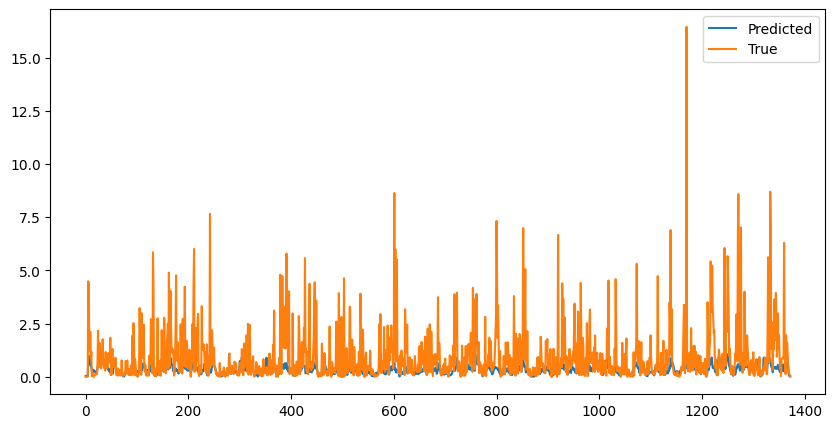

In [55]:
# plot the true counts and the predicted counts 
plt.figure(figsize=(10, 5))
plt.plot(orig_pred, label="Predicted")
plt.plot(col1a1_true_counts, label="True")
plt.legend()
plt.show()

In [56]:
# non-peak positions
non_peak_positions = []
thresh = np.nanmean(col1a1_true_counts) - 0.5 * np.nanstd(col1a1_true_counts)
print(thresh)
for i in range(len(col1a1_true_counts)):
    if col1a1_true_counts[i] < thresh:
        non_peak_positions.append(i)

0.30097162269376254


In [57]:
len(non_peak_positions)

474

In [ ]:
# motif is GTC GTC in E, P sites: 54, 54

54

In [70]:
pos_inc = {}
for i in tqdm(range(len(non_peak_positions))):
    if non_peak_positions[i] >= 2:
        new_col1a1_codon_seq = col1a1_codon_seq.copy()
        new_col1a1_codon_seq[non_peak_positions[i] - 2] = 54
        new_col1a1_codon_seq[non_peak_positions[i] - 1] = 54

        # make a prediction on the sequence
        new_col1a1_codon_seq = torch.tensor(new_col1a1_codon_seq).unsqueeze(0).to(device)
        new_pred = model(new_col1a1_codon_seq)["logits"]
        new_pred = torch.squeeze(new_pred, 0)
        new_pred = torch.sum(new_pred, 1).cpu().detach().numpy()[1:]

        orig_density = orig_pred[non_peak_positions[i]]
        new_density = new_pred[non_peak_positions[i]]

        pos_inc[non_peak_positions[i]] = 100*np.arctan(np.abs((orig_density - new_density) / (orig_density + 1e-9)))
    

  0%|          | 0/474 [00:00<?, ?it/s]

100%|██████████| 474/474 [00:15<00:00, 31.34it/s]


In [90]:
# mean increase fo codons in first positions of the sequence 
codon_init_len = 15
pos_inc_init = np.mean([pos_inc[i] for i in pos_inc.keys() if i < codon_init_len])
pos_inc_term = np.mean([pos_inc[i] for i in pos_inc.keys() if i > len(col1a1_true_counts) - codon_init_len])
pos_inc_elong = np.mean([pos_inc[i] for i in pos_inc.keys() if i >= 15 and i <= len(col1a1_true_counts) - codon_init_len])

print("Init: ", pos_inc_init, "%")
print("Term: ", pos_inc_term, "%")
print("Elong: ", pos_inc_elong, "%")

Init:  67.5091532659207 %
Term:  53.03352887291974 %
Elong:  110.08604101417572 %
